In [1]:
import numpy as np
import pandas as pd
import stereo as st
import warnings
import os
from shapely.geometry import Point, Polygon
from shapely.strtree import STRtree
import Levenshtein as lev

warnings.filterwarnings('ignore')

In [2]:
meta_data = '/home/zhanxiaojuan/data2/zhanxiaojuan/FFPE/FFPE_XCR/V1.3/M1ML150001689_L01_D04906G2/meta/M1ML150001689_L01_D04906G2.meta.gz'
meta=pd.read_csv(meta_data, sep=',')

In [6]:
# 筛选出 readID 数量大于或等于 4 的 cellID
meta['cid_umi']=meta['cid']+'_'+meta['umi']

In [7]:
meta_counts = meta.groupby('cid_umi')['readname'].nunique()

In [ ]:
valid_metas = meta_counts[meta_counts >= 4].index

In [11]:
df_tissue = pd.read_csv("/home/zhanxiaojuan/data2/zhanxiaojuan/FFPE/raw_data/D04906G2.tissue.gem",sep = '\t',comment="#")

In [12]:
bs=50
meta['x_50']=meta.x//bs*bs+bs//2
meta['y_50']=meta.y//bs*bs+bs//2
meta['loc_50']=meta['x_50'].map(str)+"_"+meta['y_50'].map(str)

In [13]:
# 读取tissue文件并设置bin50
bs=50
df_tissue['x_50']=df_tissue.x//bs*bs+bs//2
df_tissue['y_50']=df_tissue.y//bs*bs+bs//2
df_tissue['loc_50']=df_tissue['x_50'].map(str)+"_"+df_tissue['y_50'].map(str)

In [14]:
# 获取tissue内的reads
meta_in_tissue = meta[meta['loc_50'].isin(df_tissue['loc_50'])]

In [ ]:
# 保留这些 functional的XCR reads
meta_in_tissue = meta_in_tissue[meta_in_tissue['cid_umi'].isin(valid_metas)]
meta_in_tissue = meta_in_tissue[meta_in_tissue['func']=='Functional']

# 先按原来的方式给每个read分类
meta_in_tissue['TCRorBCR'] = 'BCR'
meta_in_tissue.loc[meta_in_tissue['isotype'].isin(['TRA','TRB']), 'TCRorBCR'] = 'TCR'

In [20]:
import scanpy as sc
import pandas as pd
import cv2 as cv
import numpy as np

adata = sc.read_h5ad('/home/zhanxiaojuan/data2/zhanxiaojuan/FFPE/raw_data/D04906G2.tissue_bin50.h5ad')
adata.obs['x'] = adata.obs['x'].astype(int)
adata.obs['y'] = adata.obs['y'].astype(int)

# 检查 x 和 y 列是否存在缺失值
missing_x = adata.obs['x'].isnull().any()
missing_y = adata.obs['y'].isnull().any()

print(f"列 'x' 是否存在缺失值: {missing_x}")
print(f"列 'y' 是否存在缺失值: {missing_y}")

# 找到 tissue 边缘坐标
adata.obs['X'] = adata.obs['x'] // 50
adata.obs['Y'] = adata.obs['y'] // 50
df5 = adata.obs[['X', 'Y']]

# 确定图像的大小
max_x = int(df5['X'].max())
max_y = int(df5['Y'].max())
image_size = (max_y + 1, max_x + 1)  # 图像大小为 (height, width)

# 创建一个空白的二值图像
image = np.zeros(image_size, dtype=np.uint8)

# 将 DataFrame 中的坐标点填充到图像中
for index, row in df5.iterrows():
    x, y = row['X'], row['Y']
    image[y, x] = 255  # 填充为白色（255）

# 应用 Canny 边缘检测
edges = cv.Canny(image, 50, 150)

# 获取边缘坐标
edge_coordinates = np.column_stack(np.where(edges > 0))

# 打印边缘坐标
print("边缘坐标：")
print(edge_coordinates)

df6 = pd.DataFrame(edge_coordinates, columns=['Y', 'X'])
df6['Y'] = df6['Y']* 50
df6['X'] = df6['X']* 50

# 将数据框中的 X 和 Y 列转换为 NumPy 数组
tissue_outline = df6[['X', 'Y']].values

print(tissue_outline)  # 输出数组的形状

adata.uns['tissue_outline'] = tissue_outline

列 'x' 是否存在缺失值: False
列 'y' 是否存在缺失值: False
边缘坐标：
[[  7 181]
 [  7 182]
 [  7 183]
 ...
 [408  84]
 [408  87]
 [408  90]]
[[ 9050   350]
 [ 9100   350]
 [ 9150   350]
 ...
 [ 4200 20400]
 [ 4350 20400]
 [ 4500 20400]]


为 BCR 类型创建可视化，数据点数量: 7593
为 TCR 类型创建可视化，数据点数量: 2945
已保存 TCR 和 BCR 组合绘图到: /home/zhanxiaojuan/data1/zhanxiaojuan/PRCA033509/fuji/figure/D04906G2_TCR_BCR_simplified_tissue.png


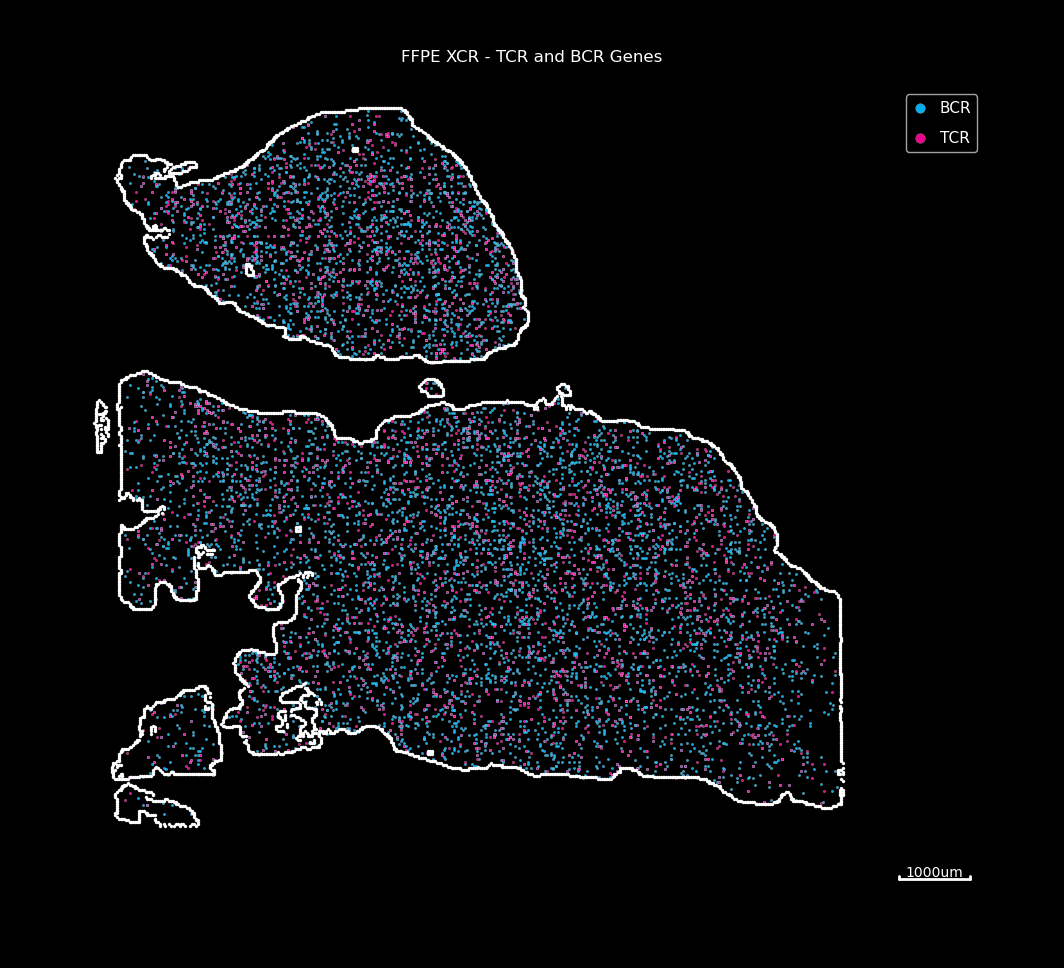

In [28]:
# 在同一个图上绘制TCR和BCR，只按大类显示
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# 确保figure目录存在
os.makedirs('/home/zhanxiaojuan/data1/zhanxiaojuan/PRCA033509/fuji/figure', exist_ok=True)

# 创建新的图形
plt.figure(figsize=(10, 10))

# 创建带有黑色背景的图
sns.set_theme(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})

# 创建一个空的图表
ax = plt.gca()

# 为TCR和BCR指定颜色
clone_colors = {
    'TCR': "#ed008c",
    'BCR': "#00aeef"
}

for clone_type in ['BCR']:
    # 筛选特定类型的数据
    clone_data = meta_in_tissue[meta_in_tissue['TCRorBCR'] == clone_type]
    clone_data = clone_data.drop_duplicates(subset=['loc'])
    
    if len(clone_data) == 0:
        print(f"没有找到 {clone_type} 类型的数据点")
        continue
    
    print(f"为 {clone_type} 类型创建可视化，数据点数量: {len(clone_data)}")
    
    # 绘制该类型的所有点
    color = clone_colors.get(clone_type)
    sns.scatterplot(
        x="x_50", y="y_50", 
        data=clone_data,
        s=3, color=color, alpha=1,
        label=f'{clone_type}',
        ax=ax
    )

# 按照Clone_type绘制点
for clone_type in ['TCR']:
    # 筛选特定类型的数据
    clone_data = meta_in_tissue[meta_in_tissue['TCRorBCR'] == clone_type]
    clone_data = clone_data.drop_duplicates(subset=['loc'])
    
    if len(clone_data) == 0:
        print(f"没有找到 {clone_type} 类型的数据点")
        continue
    
    print(f"为 {clone_type} 类型创建可视化，数据点数量: {len(clone_data)}")
    
    # 绘制该类型的所有点
    color = clone_colors.get(clone_type)
    sns.scatterplot(
        x="x_50", y="y_50", 
        data=clone_data,
        s=3, color=color, alpha=1,
        label=f'{clone_type}',
        ax=ax
    )

# 然后绘制组织边界点（白色）
tissue_df = pd.DataFrame(tissue_outline, columns=['x', 'y'])
sns.scatterplot(
    x="x", y="y", 
    data=tissue_df,
    s=5, color='white', alpha=1.0,
    ax=ax
)

# 设置图表属性
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_title('FFPE XCR - TCR and BCR Genes', fontsize=12, color='white')
ax.tick_params(axis='both', colors='white')
ax.grid(False)
ax.invert_yaxis()

# 设置等比例
ax.set_aspect('equal')

# 调整图例样式 - 放置在图像外右上角
legend = ax.legend(markerscale=4, 
                   loc='upper left',       # 改为左上对齐
                   bbox_to_anchor=(0.88, 0.98), # 放在图像右上角外
                   labelspacing=1.0,
                   frameon=True,           # 确保显示边框
                   fancybox=True,          # 使用圆角边框
                   shadow=True,            # 添加阴影
                   framealpha=0.8          # 设置透明度
                   )
plt.setp(legend.get_texts(), color='white')

# 添加比例尺
scalebar_length = 2000
scalebar_x = ax.get_xlim()[1] + 500
scalebar_y = ax.get_ylim()[0] + 500
scalebar_height = 200

ax.plot([scalebar_x, scalebar_x + scalebar_length], [scalebar_y, scalebar_y], color='white', lw=2)
ax.text(scalebar_x + scalebar_length / 2, scalebar_y - 200, f'1000um', color='white', ha='center', va='center', fontsize=10)
ax.plot([scalebar_x, scalebar_x], [scalebar_y - scalebar_height / 2, scalebar_y], color='white', lw=2)
ax.plot([scalebar_x + scalebar_length, scalebar_x + scalebar_length], [scalebar_y - scalebar_height / 2, scalebar_y], color='white', lw=2)


plt.tight_layout()

# 保存图像，再显示
output_file = f'/home/zhanxiaojuan/data1/zhanxiaojuan/PRCA033509/fuji/figure/D04906G2_TCR_BCR_simplified_tissue.png'
plt.savefig(output_file, dpi=600, bbox_inches='tight')
print(f"已保存 TCR 和 BCR 组合绘图到: {output_file}")

plt.show()
plt.close()